In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.externals import joblib

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#Importing the dataset 
X_dev=pd.read_csv("/home/umair/Desktop/Data Science and BI/machine learning/X_dev.csv")
y_dev=pd.read_csv("/home/umair/Desktop/Data Science and BI/machine learning/y_dev.csv")


X_dev.drop(['Unnamed: 0'], axis=1, inplace =True)
y_dev.drop(['Unnamed: 0'], axis=1, inplace =True)

In [3]:
warnings.simplefilter("ignore")

In [4]:
X_dev=X_dev.to_numpy()
y_dev=y_dev.to_numpy()

In [5]:
def MEE(y_real, y_pred):
    sum_t = 0
    for i in range(len(y_real)):
        sum_t += np.sqrt(np.power((y_real[i][0]-y_pred[i][0]), 2)+np.power((y_real[i][1]-y_pred[i][1]), 2))
    return sum_t / len(y_real)

MEE_s=make_scorer(MEE, greater_is_better=False)

In [6]:
kfold = KFold(n_splits=5, random_state=None, shuffle=True)

min_loss=float('inf')
min_loss_tr=float('inf')

all_loss = []
all_loss_tr = []
mean_loss = []
mean_loss_tr = []
sd=[]
sd_tr=[]

for k in range(1, 51, 1):
    for metric in ['minkowski']:
        tr_buf = []
        val_buf=[]
        for traing_index, test_index in kfold.split(X_dev):
            x_tr = X_dev[traing_index]
            y_tr = y_dev[traing_index]
            x_val = X_dev[test_index]
            y_val = y_dev[test_index]
            knr=KNeighborsRegressor(n_neighbors=k, metric=metric)
            knr.fit(x_tr, y_tr)
            y_pred = knr.predict(x_val)
            all_loss.append(MEE(y_val, y_pred))
            y_pred_tr = knr.predict(x_tr)
            all_loss_tr.append(MEE(y_tr, y_pred_tr))
            tr_buf.append(MEE(y_tr, y_pred_tr))
            val_buf.append(MEE(y_val, y_pred))
        mean_loss.append(np.mean(val_buf))
        sd.append(np.std(val_buf))
        mean_loss_tr.append(np.mean(tr_buf))
        sd_tr.append(np.std(tr_buf))
        tmp = np.mean(all_loss)
        tmp_tr = np.mean(all_loss_tr)
        if(tmp<min_loss):
            min_loss=tmp
            min_loss_tr=tmp_tr
            best_K = k
            best_metric = metric
print(best_K, best_metric)
print("Mean MEE on the validation",min_loss)
print("Mean MEE on the training",min_loss_tr)

32 minkowski
Mean MEE on the validation 2.937916634941768
Mean MEE on the training 2.55244635768943


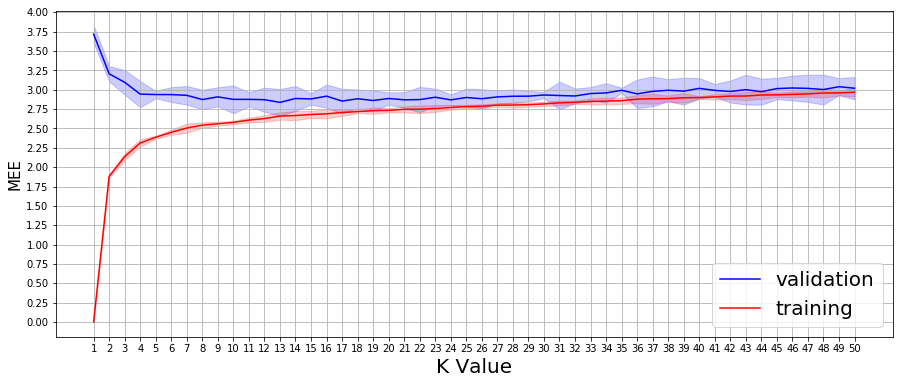

In [7]:
mean_loss=np.array(mean_loss)
mean_loss_tr=np.array(mean_loss_tr)
sd=np.array(sd)
sd_tr=np.array(sd_tr)

plt.figure(figsize=(15, 6))
x = np.arange(len(mean_loss_tr))+1
plt.plot(x, mean_loss, 'b-', label='validation')
plt.fill_between(x, mean_loss - sd, mean_loss + sd, color='b', alpha=0.2)
plt.plot(x, mean_loss_tr, 'r-', label='training')
plt.fill_between(x, mean_loss_tr - sd_tr, mean_loss_tr + sd_tr, color='r', alpha=0.2)
plt.xlabel('K Value', size=20)
plt.xticks(np.arange(1, 51))
plt.yticks(np.arange(0, 4.1, 0.25))
plt.ylabel('MEE', size=15)
plt.legend(fontsize='x-large')
plt.legend(loc=4, prop={'size': 20})
plt.grid()
plt.show()

In [8]:
from sklearn.model_selection import learning_curve
knr=KNeighborsRegressor(n_neighbors=best_K, 
                        metric=best_metric)

train_sizes, train_scores, valid_scores = learning_curve(
    knr, X_dev, y_dev, cv=kfold, scoring=MEE_s)

knrB=KNeighborsRegressor(n_neighbors=best_K, 
                        metric=best_metric)
knrB.fit(X_dev, y_dev)
joblib.dump(knrB, 'KNR_best.joblib')

['KNR_best.joblib']

In [9]:
train_scores_mean = -train_scores.mean(axis=1)
validation_scores_mean = -valid_scores.mean(axis=1)

train_scores_sd= -train_scores.std(axis=1)
validation_scores_sd = -valid_scores.std(axis=1)

In [10]:
print("Best model result:")
print("MEE on the training",train_scores_mean[-1],"with standard deviation",train_scores_sd[-1])
print("MEE on the validation",validation_scores_mean[-1],"with standard deviation",validation_scores_sd[-1])

Best model result:
MEE on the training 2.8395570028420987 with standard deviation -0.03104904439952481
MEE on the validation 2.947779747998116 with standard deviation -0.14986521233946382
